In [2]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import string

In [3]:
def read_nc_var(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    #print(file2read)
    var1 = file2read.variables[var_name]
    time = file2read.variables["time"]
    return var1, time

def runmean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def runmean(array, winlen):
    """Calculates a running mean of any timeseries using a window
    length (winlen).
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    return np.convolve(array, np.ones((winlen)) / winlen, mode='same')


def extrapolated_runmean(array, winlen):
    """Extrapolates a running mean at the beginning and end of the 
    time series. At the beginning, the window size is simply reduced. 
    At the end, which is critical for the t_anth estimation at the 
    stocktake, the running mean is linearly extrapolated. This is 
    done by calculating the slope over the last 31 (generally winlen) 
    years and adding a linear spline with this slope to the last 
    valid running mean value 17 (generally int(winlen / 2) +1) years 
    before stocktake to obtain the estimates for the last 15 
    (generally int(winlen / 2)) years before stocktake.
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    winlen=15
    array_runmean = runmean(array, winlen)

    # Reduce window size down to int(winlen / 2) + 1
    # for the first int(winlen / 2) elements.
    array_runmean[:int(winlen / 2)] = np.array([
        np.mean(array[:int(winlen / 2) + i + 1])
        for i in range(int(winlen / 2))
    ])

    # Replace the last int(winlen / 2) elements by a linear extrapolation.
    array_runmean[-int(winlen / 2):] =\
        array_runmean[-int(winlen / 2) - 1]\
        + np.polyfit(np.arange(winlen), array[-winlen:], deg=1)[0]\
        * np.arange(1, int(winlen / 2) + 1)

    return array_runmean

def extrapolate_until_2000(array,startyear,years):
    winlen=15
    
    length_ts_1905_2020 = 2022-startyear 
    
    array_extrapolated = np.zeros(length_ts_1905_2020)
    array_extrapolated[0:len(years)] = array[0:len(years)]
    
    years_missing=2022-(startyear+len(years))
    array_extrapolated[-years_missing:]=array[-1]\
    + np.polyfit(np.arange(years_missing), array[-years_missing:], deg=1)[0]\
    * np.arange(1, years_missing + 1 )
    return array_extrapolated


trend coastal temp ERA since 1980s= 1.85578562884439
trend coastal temp ERA since 1900s= 1.5776179487433533
trend coastal temp ERA since 1980s= 1.0723708555431026
trend coastal temp ERA since 1900s= 1.2131975594240298


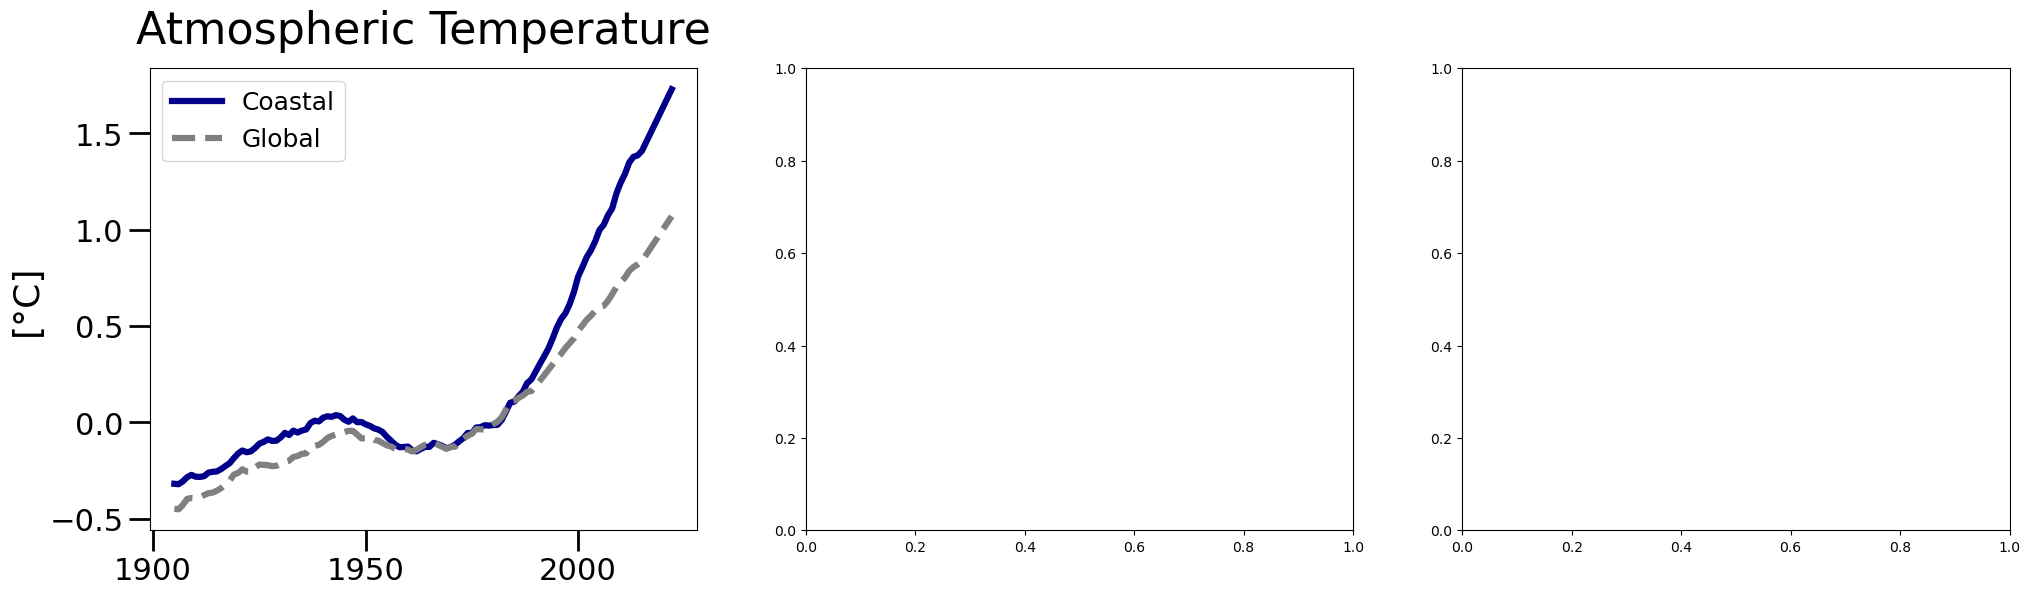

In [4]:
fig, ax =  plt.subplots(1,3,figsize=(24,6))

####Temperature
#### Coastal Ocean
#### Era 20c
file2read = nc.Dataset("analysis/ERA20C/era20c_temp_coastal_fldmean.nc",'r')
coastal_temp_era20c = file2read.variables["var167"]
coastal_temp_era20c = np.squeeze(coastal_temp_era20c[0::])
coastal_temp_era20c_runmean= extrapolated_runmean(coastal_temp_era20c,15)
#### ERA5
file2read = nc.Dataset("analysis/ERA5/era5_yearmean_coastal_fldmean.nc",'r')
coastal_temp_era5 = file2read.variables["var167"]
coastal_temp_era5 = np.squeeze(coastal_temp_era5[0::])
coastal_temp_era5_runmean= extrapolated_runmean(coastal_temp_era5,15)
coastal_temp_era5_corr = (coastal_temp_era5-np.mean(coastal_temp_era5_runmean[9]))[10::]
#### Combine
coastal_temp_era_combined = np.append(coastal_temp_era20c,coastal_temp_era20c_runmean[-1]+coastal_temp_era5_corr)
coastal_temp_era_runmean = extrapolated_runmean(coastal_temp_era_combined,15)

#### Plot
years = np.arange(1905,1905+len(coastal_temp_era_runmean[:]))
ax[0].plot(years,coastal_temp_era_runmean-np.mean(coastal_temp_era_runmean[70:80]),color="darkblue",linewidth=4.5)
ax[0].set_title("Atmospheric Temperature",fontsize=32,pad=18)
ax[0].set_ylabel("[°C]",fontsize=26)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].tick_params('both', length=15, width=2, which='major')
fig.savefig("Atmospheric_T_CO.png",dpi=300,bbox_inches="tight")

var_runmean_trend,a = np.polyfit(years[75::], coastal_temp_era_runmean[75::], 1)
print("trend coastal temp ERA since 1980s=",var_runmean_trend*(len(np.arange(1980,2022))))

var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_era_runmean[0::], 1)
print("trend coastal temp ERA since 1900s=",var_runmean_trend*(len(np.arange(1905,2022))))


####Temperature
#### Global 
#### Era 20c
file2read = nc.Dataset("analysis/ERA20C/era20c_temp_fldmean.nc",'r')
coastal_temp_era20c = file2read.variables["var167"]
coastal_temp_era20c = np.squeeze(coastal_temp_era20c[0::])
coastal_temp_era20c_runmean= extrapolated_runmean(coastal_temp_era20c,15)
#### ERA5
file2read = nc.Dataset("analysis/ERA5/era5_yearmean_fldmean.nc",'r')
coastal_temp_era5 = file2read.variables["var167"]
coastal_temp_era5 = np.squeeze(coastal_temp_era5[0::])
coastal_temp_era5_runmean= extrapolated_runmean(coastal_temp_era5,15)
coastal_temp_era5_corr = (coastal_temp_era5-np.mean(coastal_temp_era5_runmean[9]))[10::]
#### Combine
coastal_temp_era_combined = np.append(coastal_temp_era20c,coastal_temp_era20c_runmean[-1]+coastal_temp_era5_corr)
coastal_temp_era_runmean = extrapolated_runmean(coastal_temp_era_combined,15)

#### Plot
years = np.arange(1905,1905+len(coastal_temp_era_runmean[:]))
ax[0].plot(years,coastal_temp_era_runmean-np.mean(coastal_temp_era_runmean[70:80]),color="grey",linestyle="dashed",linewidth=4.5)
ax[0].set_title("Atmospheric Temperature",fontsize=32,pad=18)
ax[0].set_ylabel("[°C]",fontsize=26)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].tick_params('both', length=15, width=2, which='major')
fig.savefig("Atmospheric_T_CO.png",dpi=300,bbox_inches="tight")

var_runmean_trend,a = np.polyfit(years[75::], coastal_temp_era_runmean[75::], 1)
print("trend coastal temp ERA since 1980s=",var_runmean_trend*(len(np.arange(1980,2022))))

var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_era_runmean[0::], 1)
print("trend coastal temp ERA since 1900s=",var_runmean_trend*(len(np.arange(1905,2022))))

ax[0].legend(["Coastal","Global"],fontsize=18)

trend precip coastal ocean ICON since 1980s= 66.12790642442539
trend precip coastal ocean ICON since 1900s= 140.32673483082803
procentual trend precip coastal ocean ICON since 1900s= 14.851881502675795 %
trend precip global ocean ICON since 1980s= 21.48837790132343
trend precip global ocean ICON since 1900s= 37.572541071162796
procentual trend precip global ocean ICON since 1900s= 3.6856322642499153 %


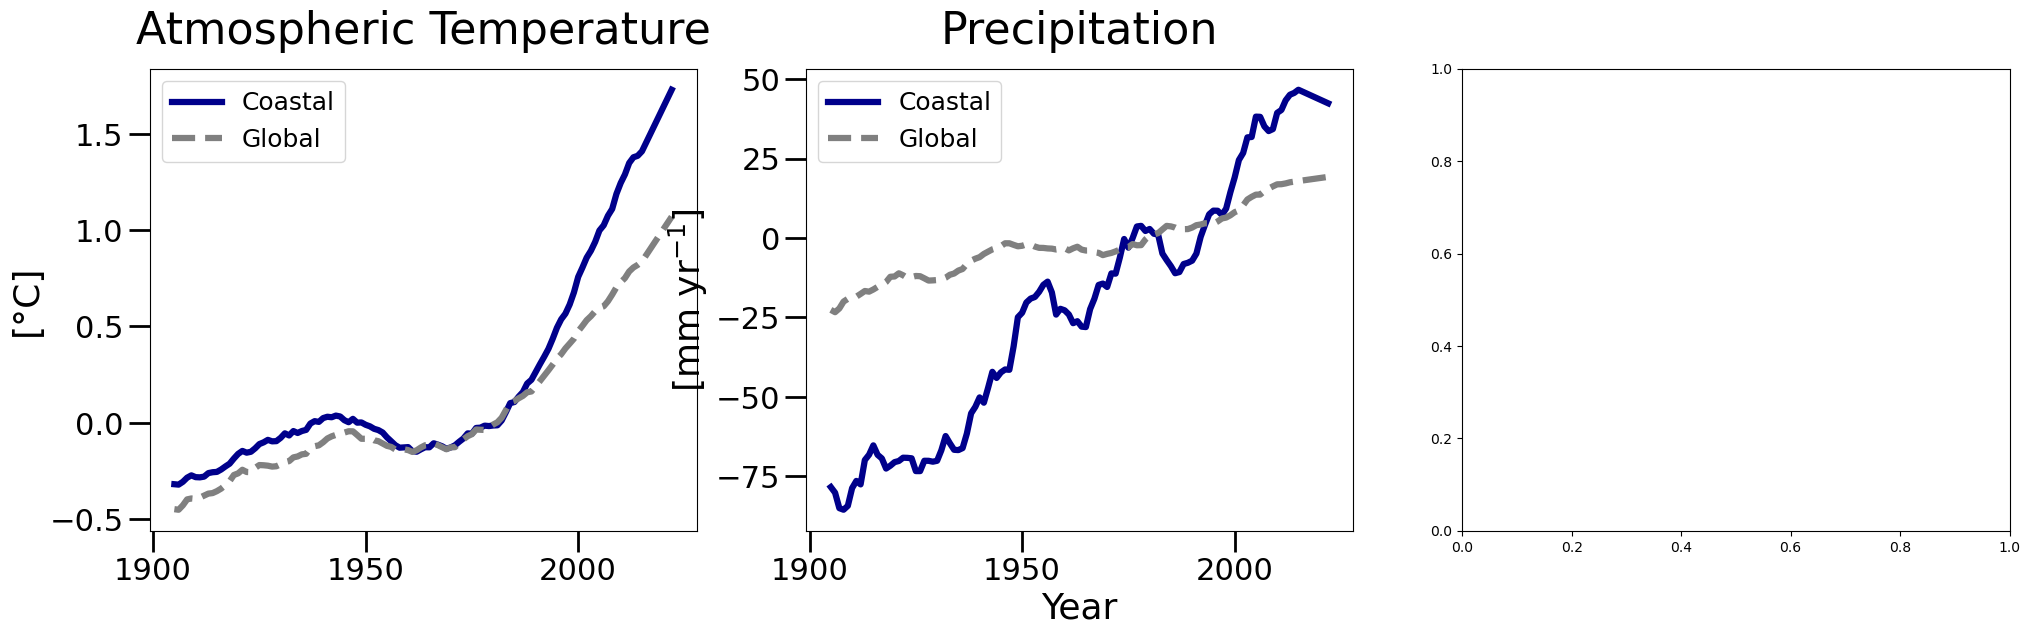

In [5]:
#### Coastal Ocean
#### Era 20c
file2read = nc.Dataset("analysis/ERA20C/era20c_prec_coastal_fldmean.nc",'r')
coastal_temp_era20c = file2read.variables["var228"]
coastal_temp_era20c = np.squeeze(coastal_temp_era20c[0::])*60*60*24*365*1000 ## unit from kg s to mm a-1
coastal_temp_era20c_runmean= extrapolated_runmean(coastal_temp_era20c,15)
#### ERA5
file2read = nc.Dataset("analysis/ERA5/era5_yearmean_coastal_fldmean.nc",'r')
coastal_temp_era5 = file2read.variables["var228"]
coastal_temp_era5 = np.squeeze(coastal_temp_era5[0::])
coastal_temp_era5_runmean= extrapolated_runmean(coastal_temp_era5,15)
coastal_temp_era5_corr = (coastal_temp_era5-np.mean(coastal_temp_era5_runmean[9]))[10::]
#### Combine
coastal_temp_era_combined = np.append(coastal_temp_era20c,coastal_temp_era20c_runmean[-1]+coastal_temp_era5_corr)
coastal_temp_era_runmean = extrapolated_runmean(coastal_temp_era_combined,15)

years = np.arange(1905,1905+len(coastal_temp_era_runmean[:]))
ax[1].plot(years,coastal_temp_era_runmean-np.mean(coastal_temp_era_runmean[70:80]),color="darkblue",linewidth=4.5)
ax[1].set_title("Precipitation",fontsize=32,pad=18)
ax[1].set_ylabel("[mm yr$^{-1}$]",fontsize=26)
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].tick_params('both', length=15, width=2, which='major')
fig.savefig("Atmospheric_T_CO.png",dpi=300,bbox_inches="tight")

var_runmean_trend,a = np.polyfit(years[75::], coastal_temp_era_runmean[75::], 1)
print("trend precip coastal ocean ICON since 1980s=",var_runmean_trend*(len(np.arange(1980,2022))))
var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_era_runmean[0::], 1)
print("trend precip coastal ocean ICON since 1900s=",var_runmean_trend*(len(np.arange(1900,2022))))
var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_era_runmean[0::], 1)
print("procentual trend precip coastal ocean ICON since 1900s=",var_runmean_trend*(len(np.arange(1900,2022)))/np.mean(coastal_temp_era_runmean[0:15])*100,"%")


#### Global Ocean
#### Era 20c
file2read = nc.Dataset("analysis/ERA20C/era20c_prec_fldmean.nc",'r')
coastal_temp_era20c = file2read.variables["var228"]
coastal_temp_era20c = np.squeeze(coastal_temp_era20c[0::])*60*60*24*365*1000 ## unit from kg s to mm a-1
coastal_temp_era20c_runmean= extrapolated_runmean(coastal_temp_era20c,15)
#### ERA5
file2read = nc.Dataset("analysis/ERA5/era5_yearmean_fldmean.nc",'r')
coastal_temp_era5 = file2read.variables["var228"]
coastal_temp_era5 = np.squeeze(coastal_temp_era5[0::])
coastal_temp_era5_runmean= extrapolated_runmean(coastal_temp_era5,15)
coastal_temp_era5_corr = (coastal_temp_era5-np.mean(coastal_temp_era5_runmean[9]))[10::]
#### Combine
coastal_temp_era_combined = np.append(coastal_temp_era20c,coastal_temp_era20c_runmean[-1]+coastal_temp_era5_corr)
coastal_temp_era_runmean = extrapolated_runmean(coastal_temp_era_combined,15)

years = np.arange(1905,1905+len(coastal_temp_era_runmean[:]))
ax[1].plot(years,(coastal_temp_era_runmean-np.mean(coastal_temp_era_runmean[70:80])),color="grey",linewidth=4.5,linestyle="dashed")
ax[1].set_title("Precipitation",fontsize=32,pad=18)
ax[1].set_ylabel("[mm yr$^{-1}$]",fontsize=26)
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].tick_params('both', length=15, width=2, which='major')
ax[1].set_xlabel("Year",fontsize=26)
fig.savefig("Atmospheric_T_CO.png",dpi=300,bbox_inches="tight")

var_runmean_trend,a = np.polyfit(years[75::], coastal_temp_era_runmean[75::], 1)
print("trend precip global ocean ICON since 1980s=",var_runmean_trend*(len(np.arange(1980,2022))))
var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_era_runmean[0::], 1)
print("trend precip global ocean ICON since 1900s=",var_runmean_trend*(len(np.arange(1900,2022))))
var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_era_runmean[0::], 1)
print("procentual trend precip global ocean ICON since 1900s=",var_runmean_trend*(len(np.arange(1900,2022)))/np.mean(coastal_temp_era_runmean[0:15])*100,"%")
ax[1].legend(["Coastal","Global"],fontsize=18)
fig

trend sst coastal ocean ICON= 0.04120785074820361
trend sst coastal ocean ICON= -0.0016564195633669407
106
106
trend sst coastal ocean ICON= 0.08364925359934391
trend sst coastal ocean ICON= 0.023091581896518557


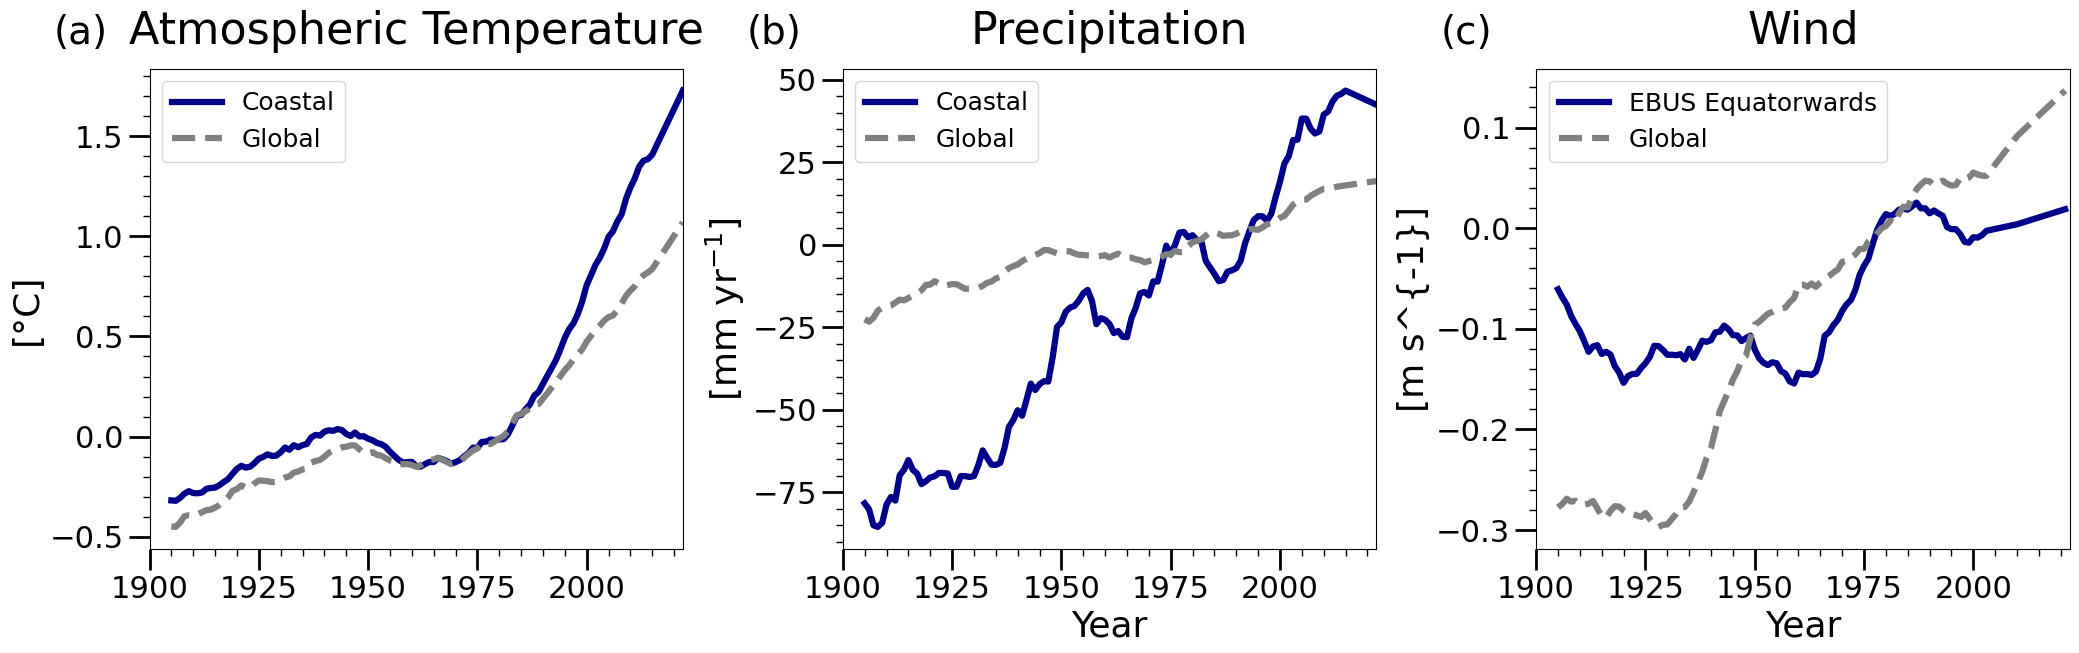

In [6]:
#### Coastal Ocean
file2read = nc.Dataset("analysis/ERA20C/era20c_wind_coastal_ccs_fldmean.nc",'r')
coastal_temp_ccs = np.squeeze(file2read.variables["var165"])
file2read = nc.Dataset("analysis/ERA20C/era20c_wind_coastal_peru_fldmean.nc",'r')
coastal_temp_peru = np.squeeze(file2read.variables["var165"])
file2read = nc.Dataset("analysis/ERA20C/era20c_wind_coastal_benguela_fldmean.nc",'r')
coastal_temp_benguela = np.squeeze(file2read.variables["var165"])
file2read = nc.Dataset("analysis/ERA20C/era20c_wind_coastal_canary_fldmean.nc",'r')
coastal_temp_canary = np.squeeze(file2read.variables["var165"])
coastal_temp = np.mean([np.mean([np.mean([coastal_temp_ccs,coastal_temp_peru],axis=0),coastal_temp_benguela],axis=0),coastal_temp_canary],axis=0)
coastal_temp_runmean = extrapolated_runmean(coastal_temp,15)
years_temp = np.arange(1905,1905+len(coastal_temp_runmean[:]))
coastal_temp_runmean_2000 = extrapolate_until_2000(coastal_temp_runmean,1905,years_temp)
years = np.arange(1905,1905+len(coastal_temp_runmean_2000[:]))
ax[2].plot(years,(coastal_temp_runmean_2000-np.mean(coastal_temp_runmean_2000[70:80])),color="darkblue",linewidth=4.5)
ax[2].set_title("Wind",fontsize=32,pad=18)
ax[2].set_ylabel("[m s$^{-1}$]",fontsize=26)
ax[2].tick_params(axis='both', which='major', labelsize=22)
ax[2].tick_params('both', length=15, width=2, which='major')
fig.savefig("Atmospheric_T_CO.png",dpi=300,bbox_inches="tight")

var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_runmean_2000[0::], 1)
print("trend sst coastal ocean ICON=",var_runmean_trend*(len(np.arange(1905,2020)))/(np.mean(coastal_temp_runmean_2000[0:15])))
var_runmean_trend,a = np.polyfit(years[75::], coastal_temp_runmean_2000[75::], 1)
print("trend sst coastal ocean ICON=",var_runmean_trend*(len(np.arange(1980,2022)))/(np.mean(coastal_temp_runmean_2000[0:15])))


#### Global Ocean
file2read = nc.Dataset("analysis/ERA20C/era20c_wind_fldmean.nc",'r')
coastal_temp = file2read.variables["var165"]
coastal_temp = np.squeeze(coastal_temp[0::])
print(len(coastal_temp)) 
coastal_temp_runmean = extrapolated_runmean(coastal_temp,15)
years_temp = np.arange(1905,1905+len(coastal_temp_runmean[:]))
print(len(coastal_temp_runmean)) 
coastal_temp_runmean_2000 = extrapolate_until_2000(coastal_temp_runmean,1905,years_temp)

years = np.arange(1905,1905+len(coastal_temp_runmean_2000[:]))
ax[2].plot(years,(coastal_temp_runmean_2000-np.mean(coastal_temp_runmean_2000[70:80])),color="grey",linewidth=4.5,linestyle="dashed")
ax[2].set_title("Wind",fontsize=32,pad=18)
ax[2].set_ylabel("[m s^{-1}]",fontsize=26)
ax[2].tick_params(axis='both', which='major', labelsize=22)
ax[2].tick_params('both', length=15, width=2, which='major')
ax[2].set_xlabel("Year",fontsize=26)
fig.savefig("Atmospheric_T_CO.png",dpi=300,bbox_inches="tight")

var_runmean_trend,a = np.polyfit(years[0::], coastal_temp_runmean_2000[0::], 1)
print("trend sst coastal ocean ICON=",var_runmean_trend*(len(np.arange(1905,2020)))/(np.mean(coastal_temp_runmean_2000[0:15])))
var_runmean_trend,a = np.polyfit(years[75::], coastal_temp_runmean_2000[75::], 1)
print("trend sst coastal ocean ICON=",var_runmean_trend*(len(np.arange(1975,2020)))/(np.mean(coastal_temp_runmean_2000[0:15])))

ax[2].legend(["EBUS Equatorwards","Global"],fontsize=18)

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.3,hspace=0.4)

alphabet=list(string.ascii_lowercase)
count = 0
for axe in ax.reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=22)

    axe.minorticks_on()
    axe.tick_params('both', length=15, width=2, which='major')
    axe.tick_params('both', length=5, width=1, which='minor')
    axe.set_xlim(1900,2022)
    
    title_pos =axe.title.get_position()
    axe.annotate("({})".format(alphabet[count]),
            xy=([title_pos[0]-0.68,title_pos[1]+0.05]), xytext=(0, 0.5), 
            xycoords=('axes fraction', 'axes fraction'),
            textcoords='offset points',size=28)
    count = count + 1
fig.savefig("figures/drivers.png",dpi=500,bbox_inches='tight',facecolor="white")
fig

/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_2768/2512703696.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(file_name, names= ["year","CO2","CH4","N2O"],sep="     ")


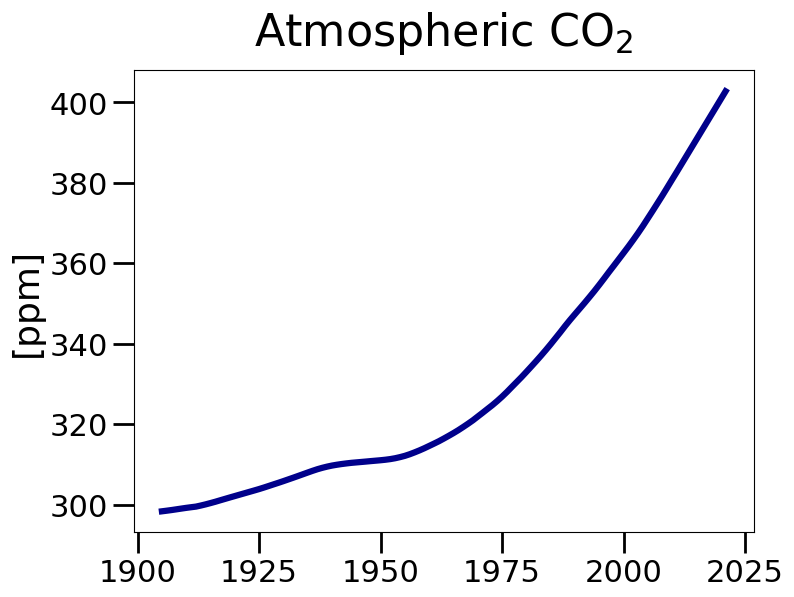

In [7]:
#### Atm CO2 ###
fig, ax =  plt.subplots(1,1,figsize=(8,6))

#define path
cwd='C:/Users/fabri/Documents/Python_scripts/Paper4'
# read atmospheric CO2
file_name="analysis/forcings/" + "atmosphericCO2.txt"
data = pd.read_csv(file_name, names= ["year","CO2","CH4","N2O"],sep="     ")
atmCO2=data[data["year"]<2015]["CO2"][0:115]
atmCO2_runmean=extrapolated_runmean(np.squeeze(np.array(atmCO2[:])),15)
years_temp = np.arange(1905,1905+len(atmCO2_runmean[:]))
atmCO2_runmean_2000=extrapolate_until_2000(atmCO2_runmean,1905,years_temp)
years = np.arange(1905,1905+len(atmCO2_runmean_2000[:]))
ax.plot(years,atmCO2_runmean_2000,color="darkblue",linewidth=4.5)
ax.set_title("Atmospheric CO$_{2}$",fontsize=32,pad=18)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params('both', length=15, width=2, which='major')
ax.set_ylabel("[ppm]",fontsize=26)
fig.savefig("Atmospheric_CO2.png",dpi=300,bbox_inches="tight")

105
105


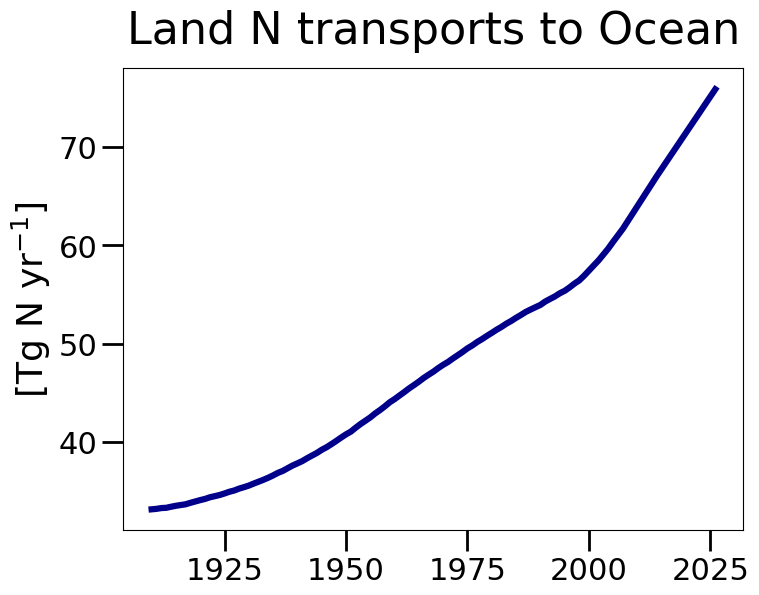

In [44]:
#### N inputs ###
fig, ax =  plt.subplots(1,1,figsize=(8,6))
 
# read river nitrogen
cwd=''
file_name = "analysis/forcings/" + "RiverNInput_globalTS.nc"
var,time = read_nc_var(cwd,file_name,"N_Input")
riv_n = np.squeeze(var[5:110])
print(len(riv_n))

# read nitrogen deposition
file_name = "analysis/forcings/" + "n_depo_coastaltotal_timeseries.nc"
var,time = read_nc_var(cwd,file_name,"ndepo")
print(len(var))
ndep_n = np.squeeze(var[0:105])/441504000

# compute total increased n input

total_n=ndep_n*14+riv_n*1E6

# plot total n input
total_n_runmean=extrapolated_runmean(np.squeeze(total_n),15)
years_temp = np.arange(1905,1905+len(total_n_runmean))
total_n_runmean_2000=extrapolate_until_2000(np.squeeze(total_n_runmean),1905,years_temp)
years = np.arange(1905+5,1905+5+len(total_n_runmean_2000[:]))
ax.plot(years,total_n_runmean_2000*1E-12,color="darkblue",linewidth=4.5)
ax.set_title("Land N transports to Ocean",fontsize=32,pad=18)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_ylabel("[Tg N yr$^{-1}$]",fontsize=26)
ax.tick_params('both', length=15, width=2, which='major')
fig.savefig("Terr_n_inputs.png",dpi=300,bbox_inches="tight")

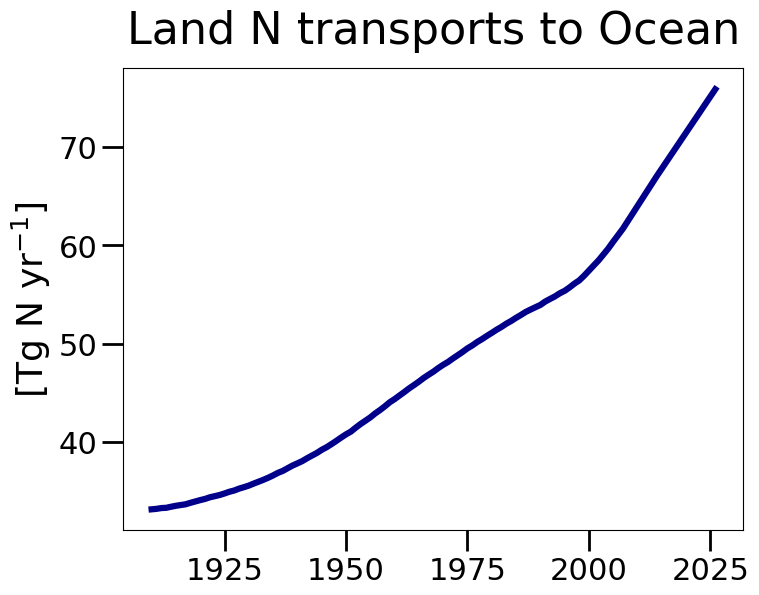

In [45]:
fig